In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-sets-cda/Nairobi_Feature_Set_final_2022-2023.csv
/kaggle/input/final-sets-cda/ludhiana_feature_set_final.csv
/kaggle/input/final-sets-cda/Ludhiana_Feature_Set_2022-2023_final_NEW.csv
/kaggle/input/final-sets-cda/Ludhiana_Feature_Set_2022-2023_final.csv
/kaggle/input/final-sets-cda/Nairobi_Feature_Set_final_2022-2023_NEW.csv
/kaggle/input/final-sets-cda/nairobi_feature_set_final.csv
/kaggle/input/model-and-scaler-new/final_model_final_CDA(1).pkl
/kaggle/input/model-and-scaler-new/scaler_final_CDA(1).pkl
/kaggle/input/model-and-scaler-new/scaler_new_improved(2).pkl
/kaggle/input/model-and-scaler-new/final_model_new_improved.pkl
/kaggle/input/model-and-scaler-new/scaler_new_improved.pkl
/kaggle/input/model-and-scaler-new/final_model_new_improved(2).pkl
/kaggle/input/final-ha-dataset/final_dataset_HA_Ludhiana_2017-2019_FINAL.csv
/kaggle/input/final-ha-dataset/final_dataset_HA_Ludhiana_2017-2019_FINAL_NEW.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_adm = pd.read_csv('/kaggle/input/final-ha-dataset/final_dataset_HA_Ludhiana_2017-2019_FINAL.csv')
df_adm['date'] = pd.to_datetime(df_adm['date'], errors='raise')
df_adm.set_index('date', inplace=True)
#df_adm.drop('date', axis=1, inplace=True)
#df_adm.dropna(inplace=True)
# Rename the columns to facilitate later stage of using fit model
df_adm = df_adm.rename(columns={
    'search_HeroDMCHeartInstitute': 'search_hospital',
})

In [4]:
ludhiana_df = pd.read_csv('/kaggle/input/final-sets-cda/ludhiana_feature_set_final.csv')
nairobi_df = pd.read_csv('/kaggle/input/final-sets-cda/nairobi_feature_set_final.csv')

# Convert 'date' column to datetime
ludhiana_df['date'] = pd.to_datetime(ludhiana_df['Unnamed: 0'])
ludhiana_df.drop('Unnamed: 0', axis=1, inplace=True)
nairobi_df['date'] = pd.to_datetime(nairobi_df['Unnamed: 0'])
nairobi_df.drop('Unnamed: 0', axis=1, inplace=True)

# Set 'date' as index
ludhiana_df.set_index('date', inplace=True)
nairobi_df.set_index('date', inplace=True)

na_cutoff = nairobi_df.index.max()

# preprocessing
nairobi_df.rename(columns={'cpi_tobacco_intoxicants__distributed': 'cpi_tobacco_intoxicants_distributed'}, inplace=True)
ludhiana_df = ludhiana_df[ludhiana_df.columns.intersection(nairobi_df.columns)]

# Exploratory Data Analysis

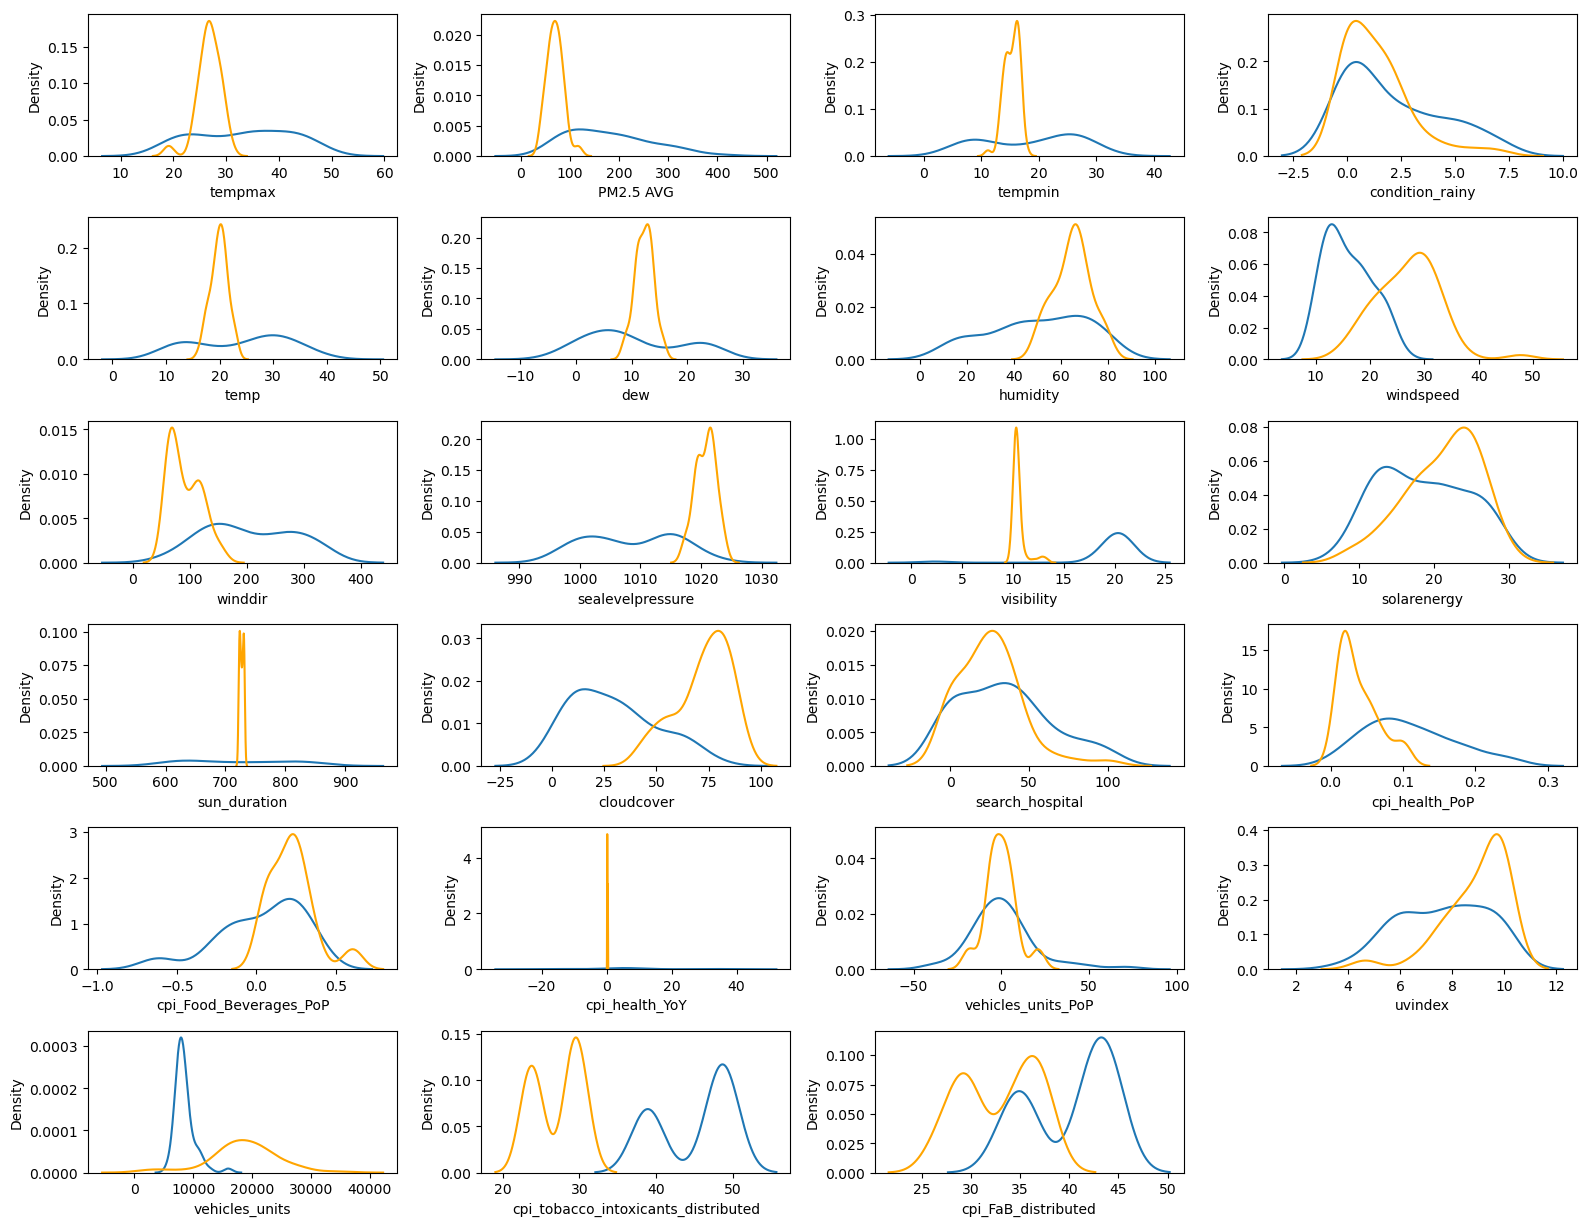

In [10]:
# Plotting the distributions of the features for both datasets
plt.figure(figsize=(16, 16))


#for i, column in enumerate(ludhiana_df.columns[1:], 1):
for i, column in enumerate(ludhiana_df.columns, 1):
    plt.subplot(8, 4, i)
    sns.kdeplot(ludhiana_df.loc[:na_cutoff][column], label='Ludhiana', color='tab:blue')
    sns.kdeplot(nairobi_df[column], label='Nairobi', color='orange')
    #plt.title(column)

plt.tight_layout()
plt.savefig('nairobi_ludhina_distributions.jpg', format='jpg', dpi=300)
plt.show()

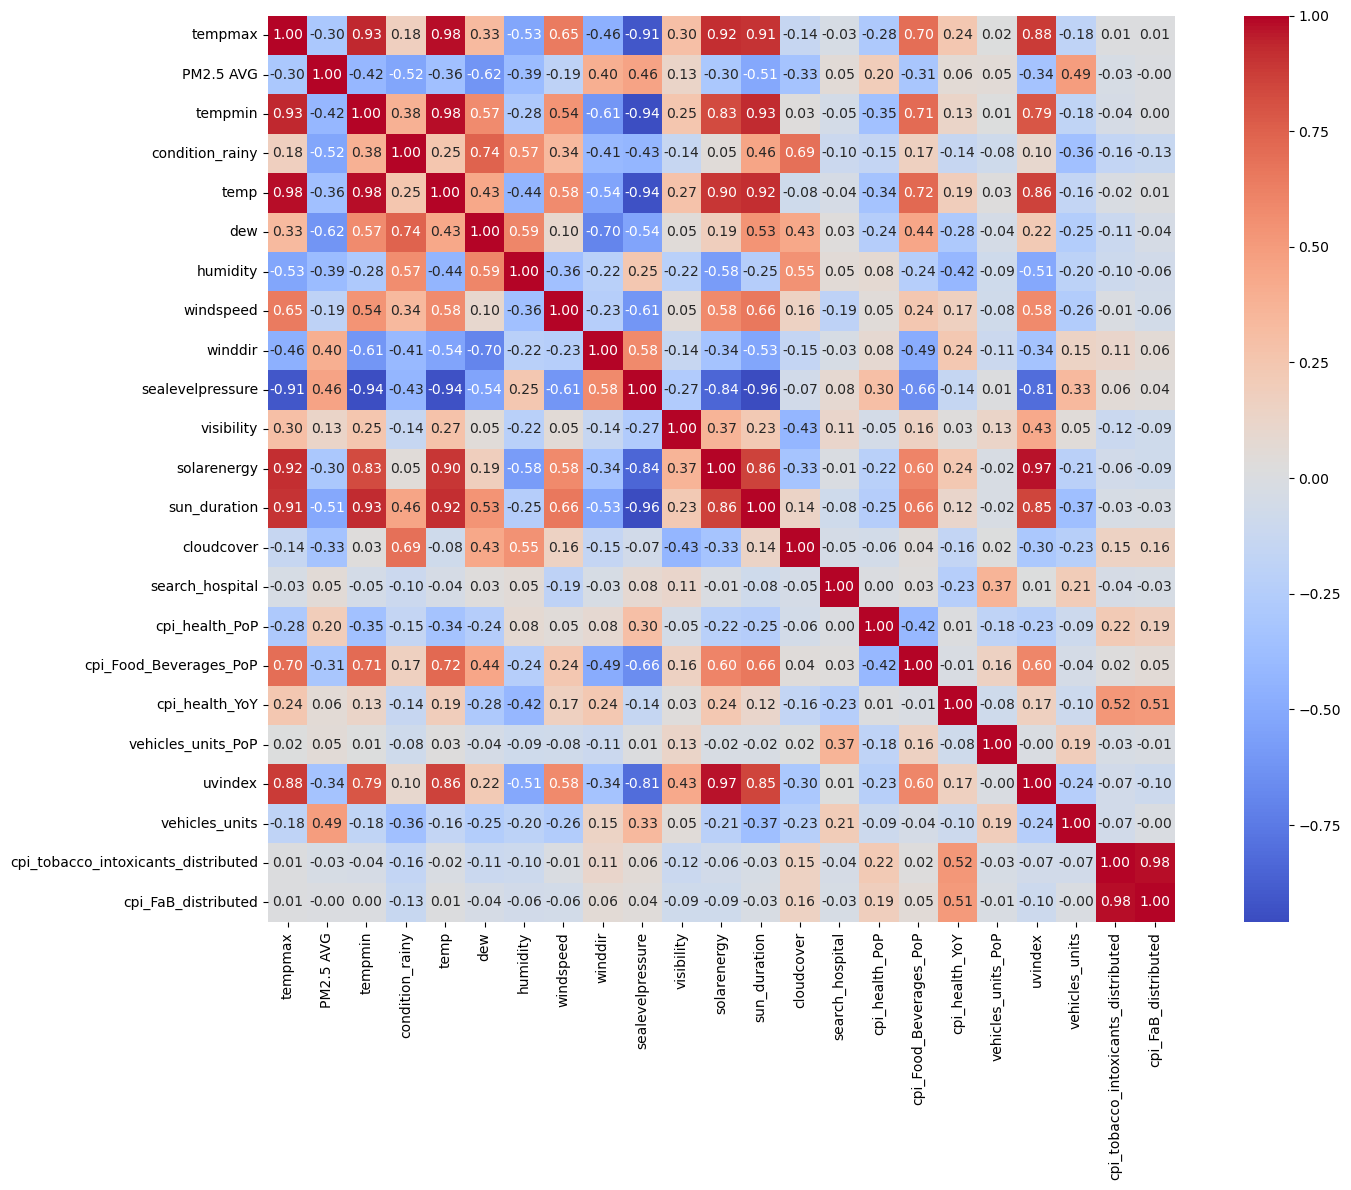

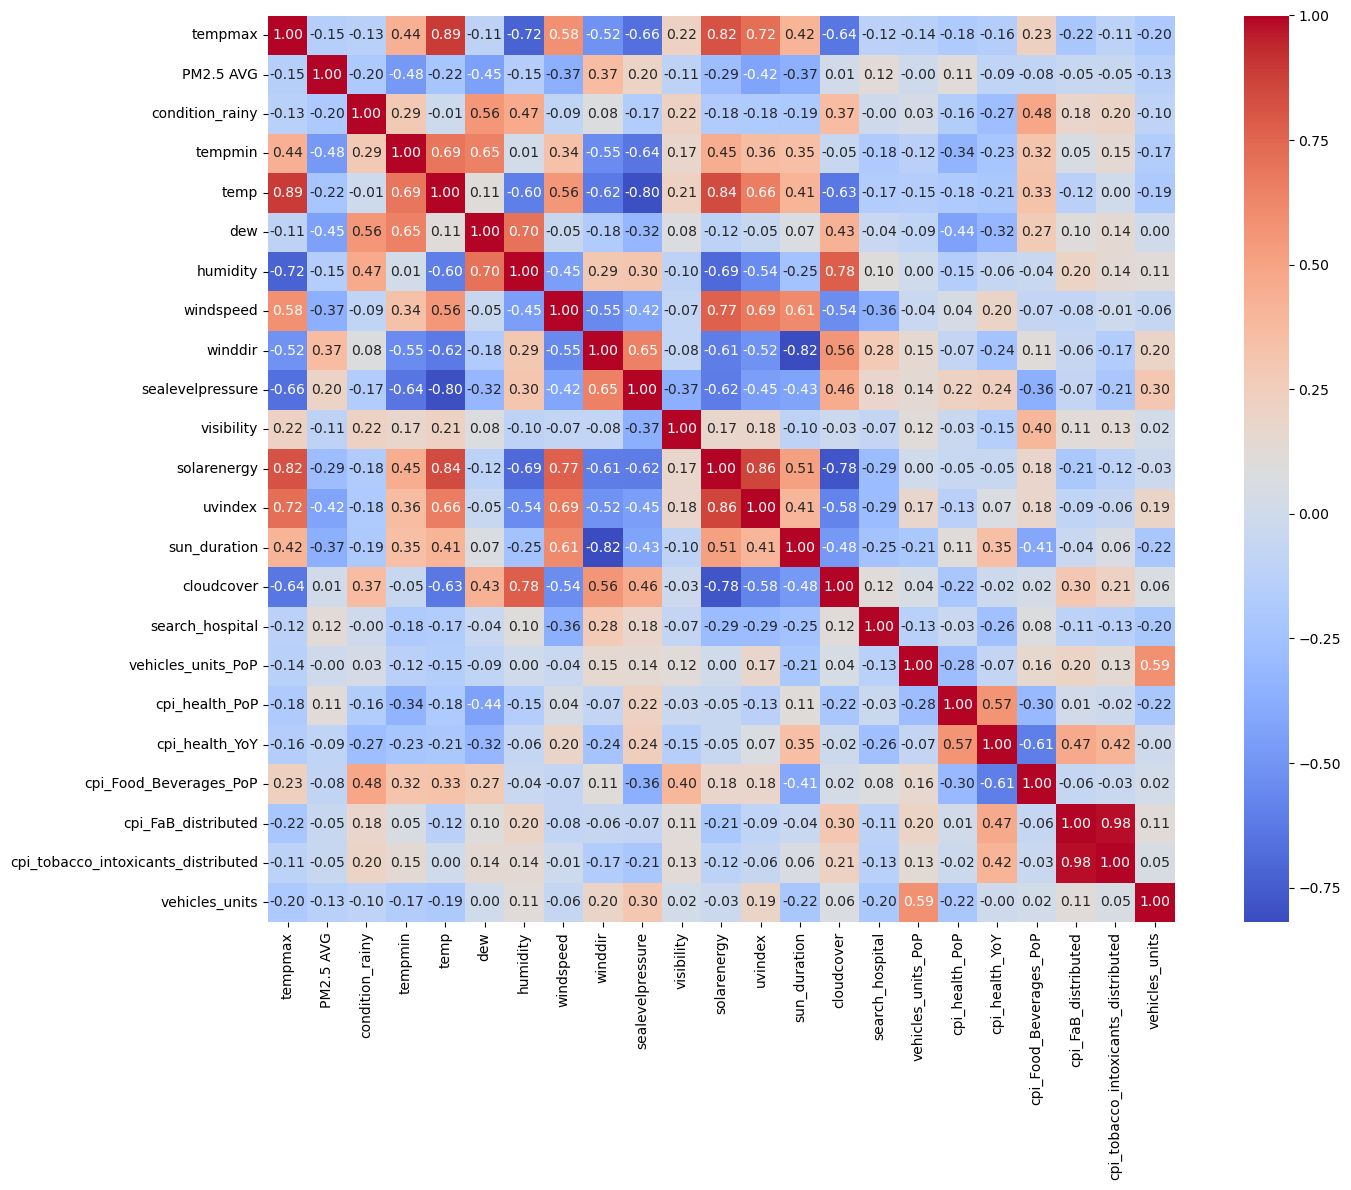

In [7]:
# Calculate correlations for both datasets
ludhiana_corr = ludhiana_df.loc[:na_cutoff].corr()
nairobi_corr = nairobi_df.corr()

# Plot correlation matrix for Ludhiana
plt.figure(figsize=(16, 12))
sns.heatmap(ludhiana_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
#plt.title("Correlation Matrix - Ludhiana Dataset")
plt.tight_layout()
plt.savefig('corr_Ludhiana_New.jpg', format='jpg', dpi=300)
plt.show()

# Plot correlation matrix for Nairobi
plt.figure(figsize=(16, 12))
sns.heatmap(nairobi_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
#plt.title("Correlation Matrix - Nairobi Dataset")
plt.tight_layout()
plt.savefig('corr_Nairobi.jpg', format='jpg', dpi=300)
plt.show()


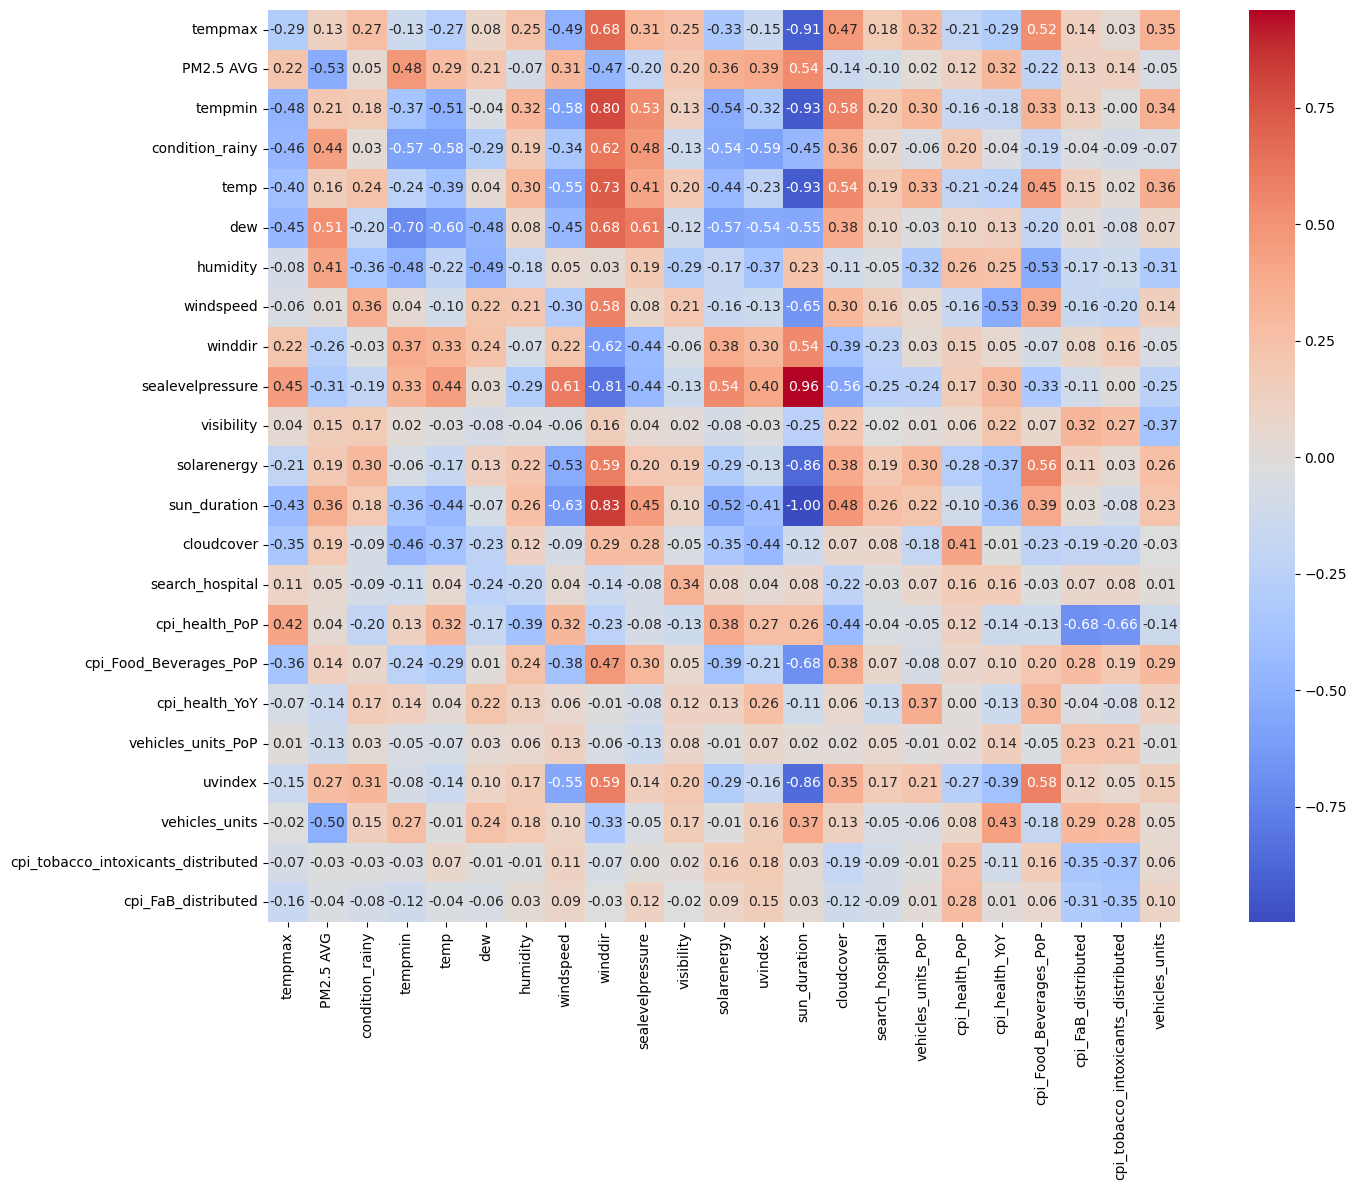

In [9]:
# Merging the datasets
merged_data = pd.merge(ludhiana_df, nairobi_df, on='date', suffixes=('_ludhiana', '_nairobi'))

# Compute correlation matrix
merged_corr = merged_data.corr()

# Filter the correlations between the same features from the two cities
same_feature_corr = merged_corr.filter(regex='_nairobi$').loc[merged_corr.index.str.endswith('_ludhiana')]

# Rename the columns and indexes for better visualization
same_feature_corr.columns = [col.replace('_nairobi', '') for col in same_feature_corr.columns]
same_feature_corr.index = [idx.replace('_ludhiana', '') for idx in same_feature_corr.index]

# Plot correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(same_feature_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
#plt.title("Correlation Matrix - Same Features Across Cities")
plt.tight_layout()
plt.savefig('corr_Ludhiana_to_Nairobi.jpg', format='jpg', dpi=300)
plt.show()


In [23]:
# Summary statistics for Ludhiana dataset
ludhiana_summary = ludhiana_df[:na_cutoff][best_features].describe().transpose()
ludhiana_summary["city"] = "Ludhiana"

# Summary statistics for Nairobi dataset
nairobi_summary = nairobi_df.describe().transpose()
nairobi_summary["city"] = "Nairobi"

# Concatenating the two summaries
summary_statistics = pd.concat([ludhiana_summary, nairobi_summary])

# Displaying the summary statistics
summary_statistics.reset_index().rename(columns={"index": "feature"})


,feature,count,mean,std,min,25%,50%,75%,max,city
0,tempmax,57.0,33.149123,9.007479,18.500000,25.400000,34.300000,41.200000,47.700000,Ludhiana
1,PM2.5 AVG,57.0,178.403509,83.889566,61.000000,104.000000,156.000000,240.000000,408.000000,Ludhiana
2,tempmin,57.0,18.560401,8.243768,4.942857,9.628571,19.971429,25.800000,31.728571,Ludhiana
3,condition_rainy,57.0,2.140351,2.255458,0.000000,0.000000,1.000000,4.000000,7.000000,Ludhiana
4,temp,57.0,24.078070,8.677474,9.671429,15.828571,26.457143,31.200000,38.900000,Ludhiana
5,dew,57.0,10.337469,8.492780,-3.071429,3.042857,8.071429,18.942857,24.628571,Ludhiana
6,humidity,57.0,50.336466,20.485120,14.114286,36.942857,51.185714,67.242857,78.957143,Ludhiana
7,windspeed,57.0,15.984085,4.308668,9.528571,12.357143,15.271429,18.942857,25.714286,Ludhiana
8,winddir,57.0,204.536341,78.508583,51.142857,134.685714,192.500000,282.185714,334.357143,Ludhiana
9,sealevelpressure,57.0,1008.484085,7.410746,995.957143,1001.971429,1006.600000,1015.242857,1022.528571,Ludhiana


# Prepare Features


In [5]:
# Helper function to create lagged features
def create_lagged_features(df, features, lag_count):
    df_lagged = pd.DataFrame(index=df.index)  # Create an empty DataFrame with the same index
    lagged_cols = []
    for feature in features:
        for i in range(1, lag_count + 1):
            new_col = df[feature].shift(i)
            new_col.name = feature + '_lag' + str(i)
            lagged_cols.append(new_col)
    df_lagged = pd.concat([df_lagged] + lagged_cols, axis=1)
    df_lagged = df_lagged.dropna()
    return df_lagged

# Helper function to create time series features
def create_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week.astype('int')
    return df

In [6]:
tmp_lu = ludhiana_df.copy()
tmp_na = nairobi_df.copy()

# Create lagged features for both datasets
tmp_lu = create_lagged_features(tmp_lu, tmp_lu.columns, 2)
tmp_na = create_lagged_features(tmp_na, tmp_na.columns, 2)

# add back variables that do not create data leakage
for col in ['cpi_health_PoP', 'cpi_Food_Beverages_PoP', 'cpi_health_YoY', 'vehicles_units_PoP']:
    tmp_lu[col] = ludhiana_df[col]
    tmp_na[col] = nairobi_df[col]

tmp_lu.dropna(inplace=True)
tmp_na.dropna(inplace=True)

# Create time features for both datasets
tmp_lu = create_time_features(tmp_lu)
tmp_na = create_time_features(tmp_na)


def lags_list(v_list, x=1, n=8):
    lags = []
    for variable in v_list:
        for i in range(x, n):
            lags.append(variable + '_lag' + str(i))
    return lags



best_features = lags_list(['tempmax',
                                 'sealevelpressure',
                                 'sun_duration',
                                 'search_hospital',
                                 'PM2.5 AVG',
                                 'windspeed',
                                 'cpi_tobacco_intoxicants_distributed',
                                 'vehicles_units',
                                 'condition_rainy',
                                 ], 1,2) + [
                                          'weekofyear',
                                          'month',
                                          'sealevelpressure_lag2',
                                          'cpi_FaB_distributed_lag2']



# Select the best performing features from both datasets
ludhiana_final = tmp_lu[best_features]
nairobi_final = tmp_na[best_features]



# Load Model & Scalar

In [7]:
import pickle
from sklearn.preprocessing import MinMaxScaler

# Load the trained model
with open('/kaggle/input/model-and-scaler-new/final_model_final_CDA(1).pkl', 'rb') as f:
    model = pickle.load(f)

# Load the scaler object
with open('/kaggle/input/model-and-scaler-new/scaler_final_CDA(1).pkl', 'rb') as f:
    scaler = pickle.load(f)

# Check if the loaded objects are correct
is_model_loaded_correctly = isinstance(model, type(model))
is_scaler_loaded_correctly = isinstance(scaler, MinMaxScaler)

print((is_model_loaded_correctly, is_scaler_loaded_correctly))

(True, True)


# Make New Predictions

In [8]:
from xgboost import XGBRegressor
ludhiana_array_scaled = scaler.transform(ludhiana_final)
nairobi_array_scaled = scaler.transform(nairobi_final)

def predictions_to_df(predictions, df):
    # Convert predictions to a Pandas Series
    predict_series = pd.Series(
        predictions,
        index=df.index,  
        name='Predicted_Admissions'
    )

    # Concatenate dataframe with the predictions
    df = pd.concat([df, predict_series], axis=1)
    

    return df

In [9]:
ludhiana_predicts = model.predict(ludhiana_array_scaled)
ludhiana_final = predictions_to_df(ludhiana_predicts, ludhiana_final)

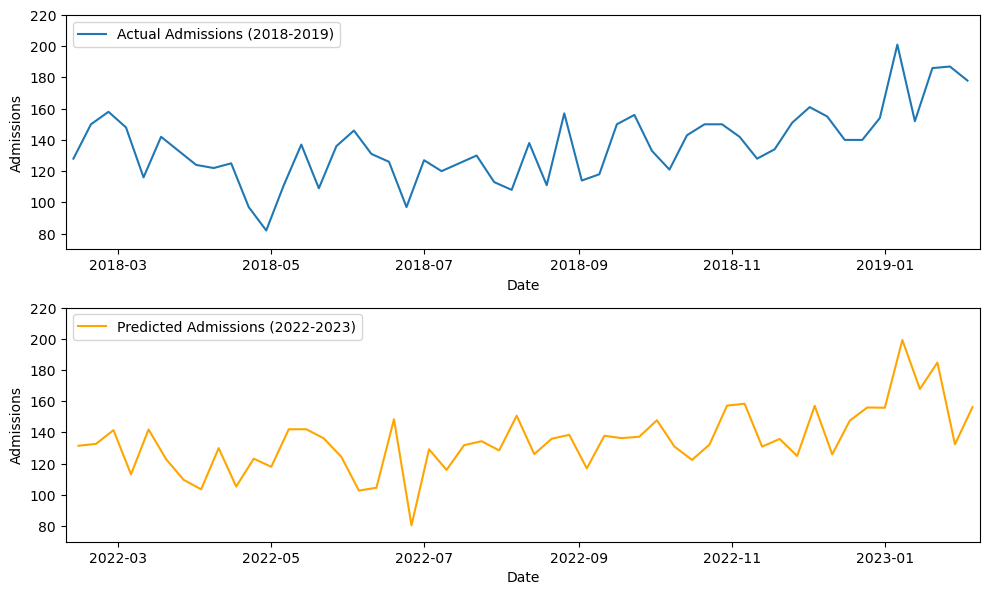

In [30]:
# Define date range
start_date_old = pd.to_datetime('2018-02-08')
end_date_old = start_date_old + pd.DateOffset(months=12)
start_date_new = pd.to_datetime('2022-02-08')
end_date_new = start_date_new + pd.DateOffset(months=12)

# Filter dataframes to only include rows within date range
df_adm_filtered = df_adm[(df_adm.index >= start_date_old) & (df_adm.index <= end_date_old)]
ludhiana_final_filtered = ludhiana_final[(ludhiana_final.index >= start_date_new) & (ludhiana_final.index <= end_date_new)]

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot actual admissions
axs[0].plot(df_adm_filtered.index, df_adm_filtered['total_admissions'])
axs[0].set( xlabel='Date', ylabel='Admissions')
axs[0].legend(["Actual Admissions (2018-2019)"])
axs[0].set_xlim([start_date_old, end_date_old])
axs[0].set_ylim([70, 220])

# Plot predicted admissions
axs[1].plot(ludhiana_final_filtered.index, ludhiana_final_filtered['Predicted_Admissions'], color='orange')
axs[1].set(title='', xlabel='Date', ylabel='Admissions')
axs[1].legend(["Predicted Admissions (2022-2023)"], loc='upper left')
axs[1].set_xlim([start_date_new, end_date_new])
axs[1].set_ylim([70, 220])

plt.tight_layout()
plt.savefig('old_admission2018-2019_and_new_predictions2022-23.jpg', format='jpg', dpi=300)
plt.show()




/tmp/ipykernel_32/2813277435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adm_filtered.loc[:, 'week_counter'] = range(1, len(df_adm_filtered) + 1)
/tmp/ipykernel_32/2813277435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ludhiana_final_filtered.loc[:, 'week_counter'] = range(1, len(ludhiana_final_filtered) + 1)


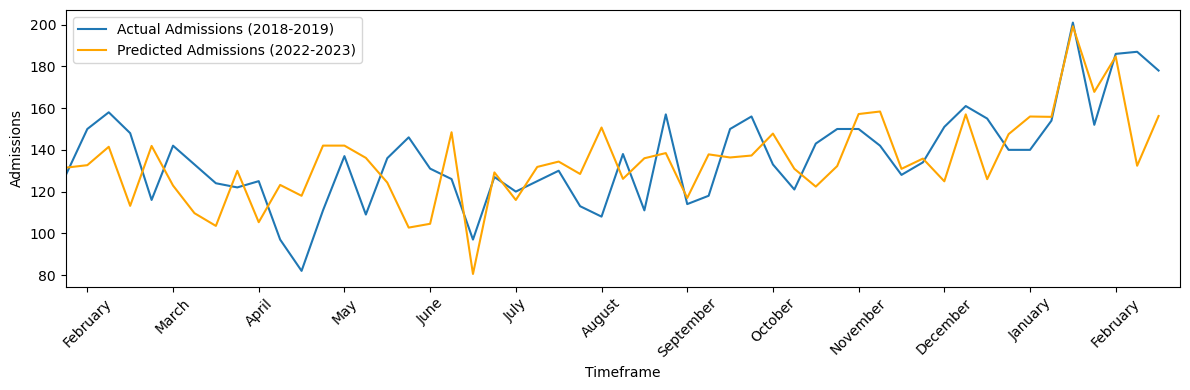

In [130]:
# Define date range
start_date_old = pd.to_datetime('2018-02-08')
end_date_old = start_date_old + pd.DateOffset(months=12)
start_date_new = pd.to_datetime('2022-02-08')
end_date_new = start_date_new + pd.DateOffset(months=12)

# Filter dataframes to only include rows within date range
df_adm_filtered = df_adm[(df_adm.index >= start_date_old) & (df_adm.index <= end_date_old)]
ludhiana_final_filtered = ludhiana_final[(ludhiana_final.index >= start_date_new) & (ludhiana_final.index <= end_date_new)]

df_adm_filtered.loc[:, 'week_counter'] = range(1, len(df_adm_filtered) + 1)
ludhiana_final_filtered.loc[:, 'week_counter'] = range(1, len(ludhiana_final_filtered) + 1)

# Plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot old data
ax.plot(df_adm_filtered['week_counter'], df_adm_filtered['total_admissions'], label="Actual Admissions (2018-2019)")

# Plot new data
ax.plot(ludhiana_final_filtered['week_counter'], ludhiana_final_filtered['Predicted_Admissions'], color='orange', label="Predicted Admissions (2022-2023)")

# Set x-axis limits
ax.set_xlim(1, len(df_adm_filtered) + 1)

# Set x-axis ticks and labels
month_names = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February']
month_ticks = range(2, len(df_adm_filtered) + 3, 4)  # Starting from the second week and then every 4th week
ax.set_xticks(month_ticks[:len(month_names)])  # Ensure the number of ticks matches the number of labels
ax.set_xticklabels(month_names, rotation=45)

ax.set(title='', xlabel='Timeframe', ylabel='Admissions')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('overlayed_admissions.jpg', format='jpg', dpi=300)

plt.show()


In [42]:
# Ensure that the two sets of data have the same length
min_length = min(len(df_adm_filtered['total_admissions']), len(ludhiana_final_filtered['Predicted_Admissions']))
total_admissions = df_adm_filtered['total_admissions'][:min_length]
predicted_admissions = ludhiana_final_filtered['Predicted_Admissions'][:min_length]

# Compute the correlation between the two sets of data
corr_coef = np.corrcoef(total_admissions, predicted_admissions)[0, 1]

corr_coef


0.5434296536727252

In [16]:
nairobi_predicts = model.predict(nairobi_array_scaled)
nairobi_final = predictions_to_df(nairobi_predicts, nairobi_final)

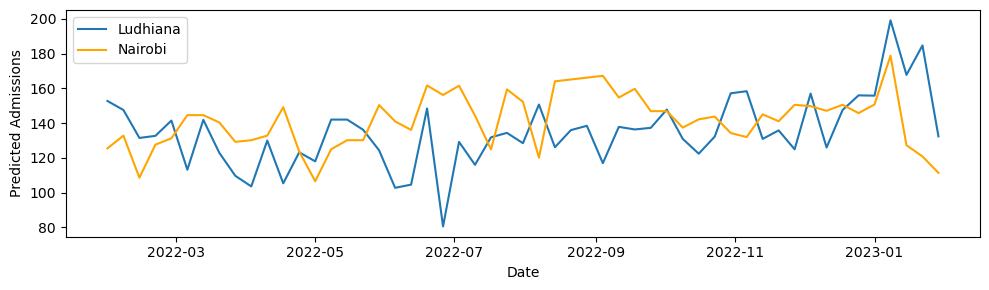

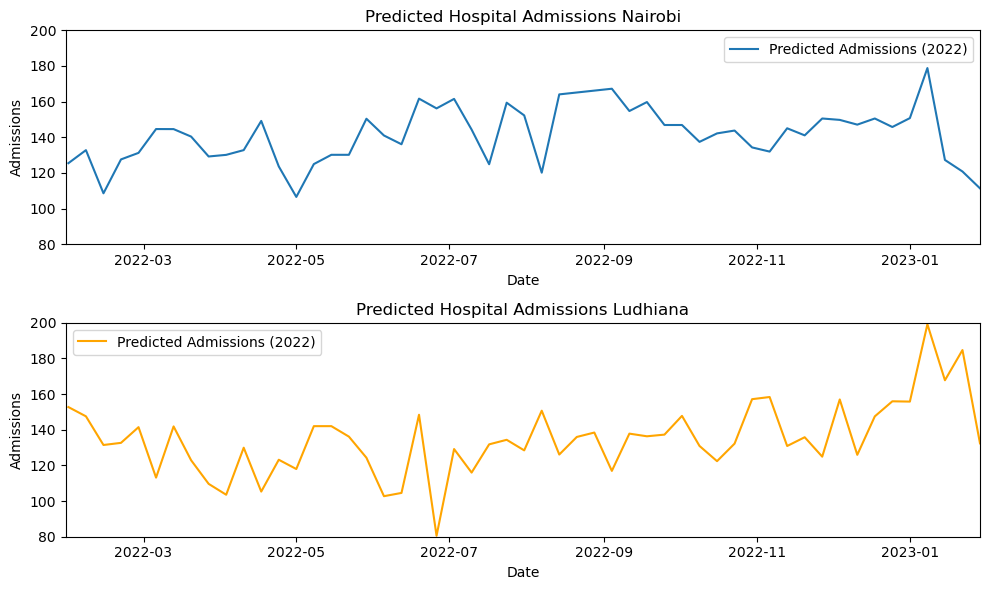

In [14]:
# Define date range
start_date = pd.to_datetime('2022-01-29')
end_date = pd.to_datetime(na_cutoff)
# Filter dataframes to only include rows within date range
nairobi_final_filtered = nairobi_final[(nairobi_final.index >= start_date) & (nairobi_final.index <= end_date)]
ludhiana_final_filtered = ludhiana_final[(ludhiana_final.index >= start_date) & (ludhiana_final.index <= end_date)]

# Line plot to visualize the predictions over time
plt.figure(figsize=(10, 3))
plt.plot(ludhiana_final_filtered.index, ludhiana_final_filtered['Predicted_Admissions'], label='Ludhiana', color='tab:blue')
plt.plot(nairobi_final_filtered.index, nairobi_final_filtered['Predicted_Admissions'], label='Nairobi', color='orange')
#plt.title('Predicted Admissions Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted Admissions')
plt.legend()
plt.tight_layout()
plt.savefig('Nairobi_vs_Ludhiana_Predicts_overlay.jpg', format='jpg', dpi=300)
plt.show()



fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot actual admissions
axs[0].plot(nairobi_final_filtered.index, nairobi_final_filtered['Predicted_Admissions'],)
axs[0].set(title='Predicted Hospital Admissions Nairobi', xlabel='Date', ylabel='Admissions')
axs[0].legend(["Predicted Admissions (2022)"])
axs[0].set_xlim([start_date, end_date])
axs[0].set_ylim([80, 200])  # Set y-limits for first subplot

# Plot predicted admissions
axs[1].plot(ludhiana_final_filtered.loc[:na_cutoff].index, ludhiana_final_filtered.loc[:na_cutoff]['Predicted_Admissions'], color='orange')
axs[1].set(title='Predicted Hospital Admissions Ludhiana', xlabel='Date', ylabel='Admissions')
axs[1].legend(["Predicted Admissions (2022)"])
axs[1].set_xlim([start_date, end_date])
axs[1].set_ylim([80, 200])

plt.tight_layout()
plt.savefig('Nairobi_vs_Ludhiana_Predicts.jpg', format='jpg', dpi=300)
plt.show()



The line plots show the predicted admissions over time for both Ludhiana and Nairobi. We can observe that the predictions for both locations exhibit some similar patterns, as well as some differences. For instance, we can see similar upward and downward trends in the predicted admissions at various points. This could suggest that the model is capturing some general patterns that apply to both locations.

In [15]:
# Descriptive Statistics for Ludhiana
print("Descriptive Statistics for Ludhiana Predicted Admissions:")
print(ludhiana_final['Predicted_Admissions'].loc[:na_cutoff].describe())

print("\n")

# Descriptive Statistics for Nairobi
print("Descriptive Statistics for Nairobi Predicted Admissions:")
print(nairobi_final['Predicted_Admissions'].describe())

print("\n")

# Correlation between the predicted admissions in both locations
correlation = ludhiana_final['Predicted_Admissions'].loc[:na_cutoff].corr(nairobi_final['Predicted_Admissions'])
print(f"Correlation between Ludhiana and Nairobi Predicted Admissions: {correlation}")


Descriptive Statistics for Ludhiana Predicted Admissions:
count     55.000000
mean     135.195602
std       20.457277
min       80.513557
25%      124.621181
50%      132.664246
75%      147.536133
max      199.202774
Name: Predicted_Admissions, dtype: float64


Descriptive Statistics for Nairobi Predicted Admissions:
count     53.000000
mean     140.566086
std       15.095405
min      106.535278
25%      130.165482
50%      142.178482
75%      150.393463
max      178.827820
Name: Predicted_Admissions, dtype: float64


Correlation between Ludhiana and Nairobi Predicted Admissions: -0.0066437487120498155


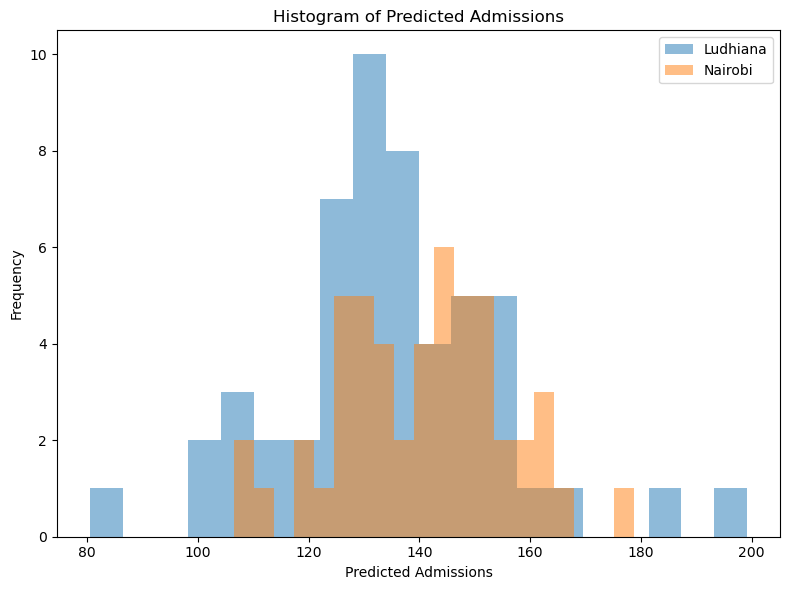

In [36]:
# Histogram to compare the frequency distributions of the predictions
plt.figure(figsize=(8, 6))
plt.hist(ludhiana_final_filtered['Predicted_Admissions'], bins=20, alpha=0.5, label='Ludhiana', )
plt.hist(nairobi_final_filtered['Predicted_Admissions'], bins=20, alpha=0.5, label='Nairobi',)
plt.title('Histogram of Predicted Admissions')
plt.xlabel('Predicted Admissions')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('Nairobi_vs_Ludhiana_Predicts_hist.jpg', format='jpg', dpi=300)
plt.show()

# Feature Importances (Ludhiana Trained Model)

<Figure size 1800x1000 with 0 Axes>

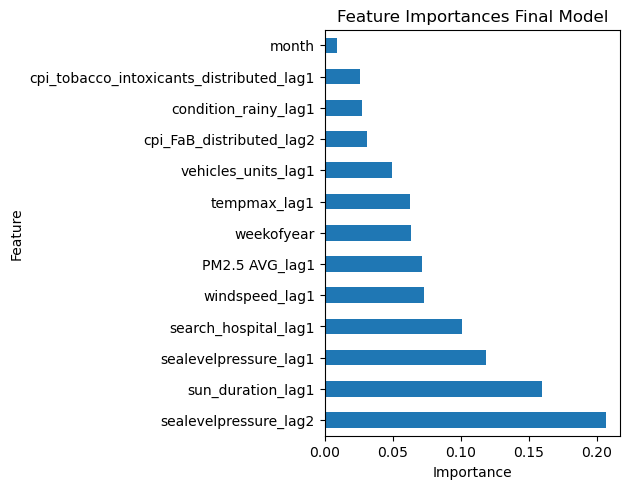

In [16]:
# Get the feature importances
importances = model.feature_importances_

# Convert the importances into a DataFrame
importances_df = pd.DataFrame({
    'Feature': ludhiana_final[:na_cutoff].drop('Predicted_Admissions', axis=1).columns,
    'Importance': importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(18, 10))
# Plot the importances
importances_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Feature Importances Final Model')
plt.tight_layout()  # Adjust layout

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('final_model_feature_importances.jpg', format='jpg', dpi=300)
plt.show()


# Sensitivity Analysis 

In [38]:
def sensitivity_analysis(df, original_predictions, features, scaler, pct_changes):
    """
    Perform sensitivity analysis on data.
    """
    # Initialize a DataFrame to store the results
    results = pd.DataFrame(index=features) 
    
    df_copy = df.copy()
        
    # Loop over each feature
    for feature in features:

        # Loop over each percentage change
        for pct_change in pct_changes:
            # Increase the feature's values by pct_change
            df_copy[feature] *= (1 + pct_change)

            # scale all features for predictions
            df_copy[features] = scaler.transform(df_copy[features])

            # Calculate new predictions
            new_predictions = model.predict(df_copy[features])

            # Calculate the difference between the new and original predictions
            difference = new_predictions - original_predictions

            # Add the average difference to the results
            results.loc[feature, f'avg_diff_pred_{pct_change*100}%'] = difference.mean()

            # Reset the dataframe for the next feature or percentage change
            df_copy = df.copy()

    return results


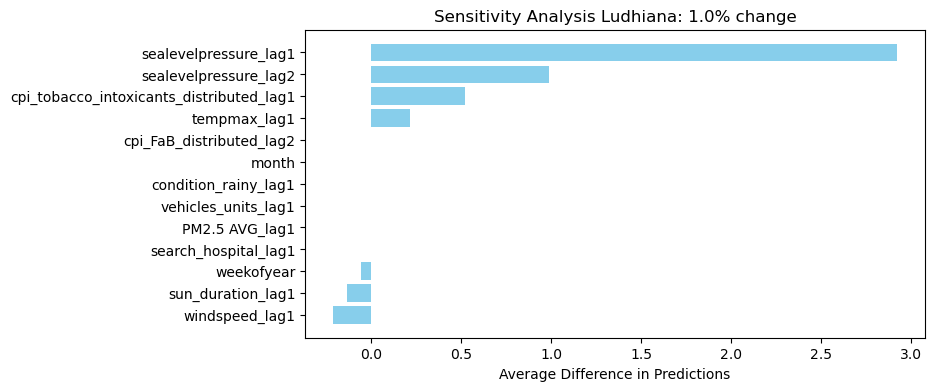

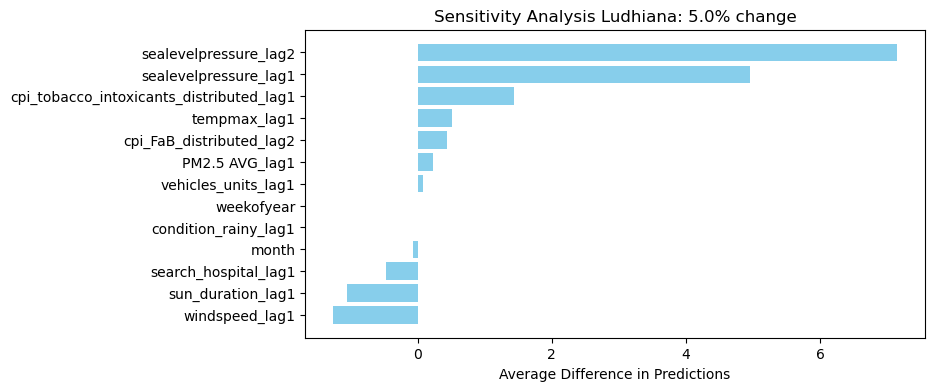

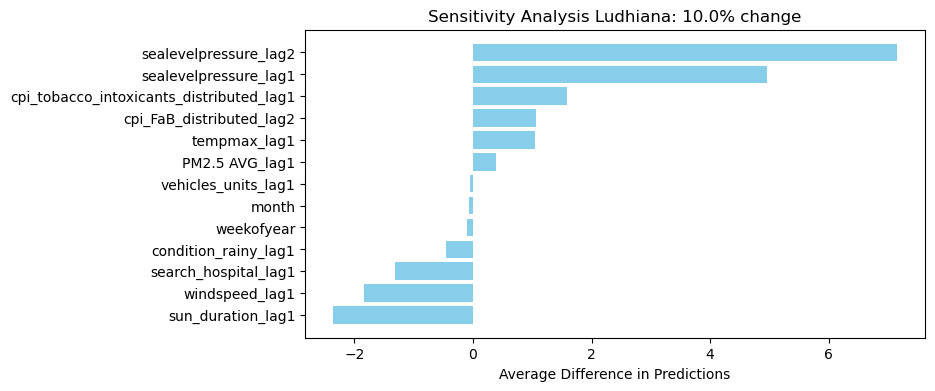

<Figure size 640x480 with 0 Axes>

In [39]:
pct_changes = [0.01, 0.05, 0.10]  # 1%, 5%, 10%
#results = sensitivity_analysis(ludhiana_final, ludhiana_predicts, best_features, scaler, pct_changes)
results_lu = sensitivity_analysis(ludhiana_final[:na_cutoff], ludhiana_predicts[:len(ludhiana_final[:na_cutoff])], best_features, scaler, [0.01, 0.05, 0.1])

# Loop over each percentage change
for pct_change in [0.01, 0.05, 0.1]:
    # Sort the results by avg_difference
    results_sorted = results_lu[f'avg_diff_pred_{pct_change*100}%'].sort_values()

    # Create a bar plot
    plt.figure(figsize=(8, 4))
    plt.barh(results_sorted.index, results_sorted.values, color='skyblue')
    plt.xlabel('Average Difference in Predictions')
    plt.title(f'Sensitivity Analysis Ludhiana: {pct_change*100}% change')
    plt.show()
    
plt.savefig('Ludhiana_Sensitivity_Analysis.jpg', format='jpg', dpi=300)


In [45]:
results_lu.to_excel('sensitivity_analysis_Ludhiana.xlsx')
results_lu

,avg_diff_pred_1.0%,avg_diff_pred_5.0%,avg_diff_pred_10.0%
tempmax_lag1,0.216556,0.506994,1.041304
sealevelpressure_lag1,2.920941,4.960979,4.960979
sun_duration_lag1,-0.135742,-1.063553,-2.353665
search_hospital_lag1,0.000000,-0.474995,-1.316710
PM2.5 AVG_lag1,0.000000,0.232130,0.382352
windspeed_lag1,-0.210487,-1.260909,-1.842165
cpi_tobacco_intoxicants_distributed_lag1,0.523035,1.437722,1.586115
vehicles_units_lag1,0.000000,0.075191,-0.055590
condition_rainy_lag1,0.000000,0.000000,-0.453308
weekofyear,-0.057730,0.001565,-0.105066


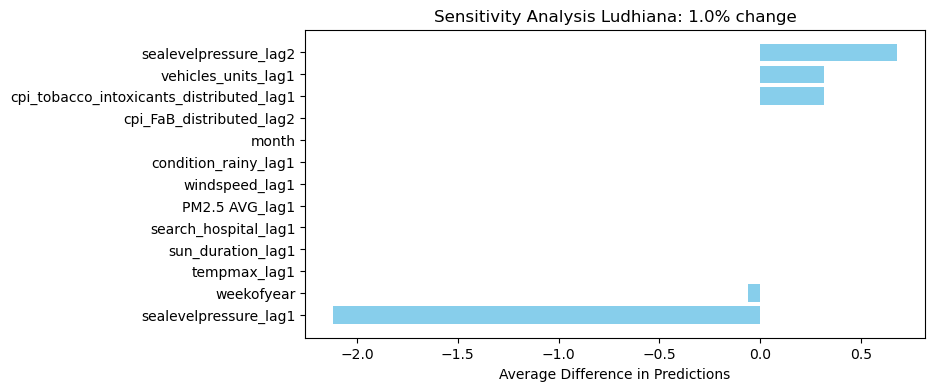

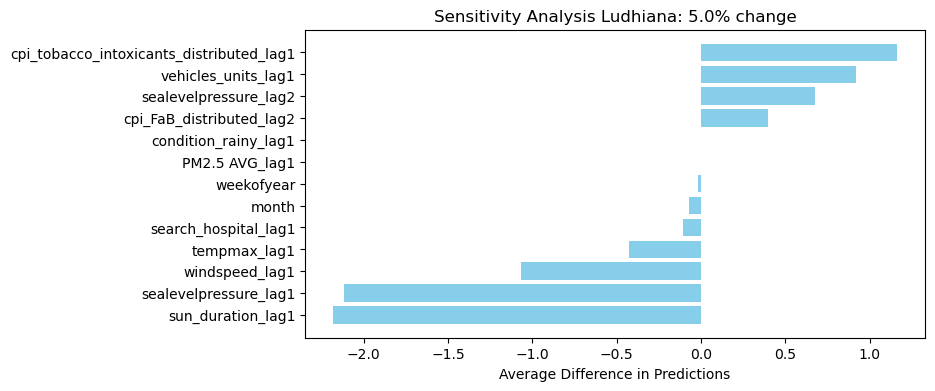

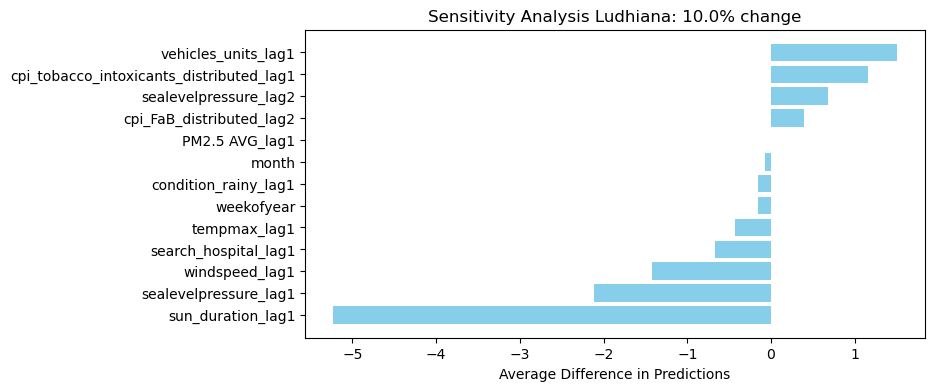

<Figure size 640x480 with 0 Axes>

In [41]:
pct_changes = [0.01, 0.05, 0.10]  # 1%, 5%, 10%
#results = sensitivity_analysis(ludhiana_final, ludhiana_predicts, best_features, scaler, pct_changes)
results_na = sensitivity_analysis(nairobi_final, nairobi_predicts, best_features, scaler, [0.01, 0.05, 0.1])

# Loop over each percentage change
for pct_change in [0.01, 0.05, 0.1]:
    # Sort the results by avg_difference
    results_sorted = results_na[f'avg_diff_pred_{pct_change*100}%'].sort_values()

    # Create a bar plot
    plt.figure(figsize=(8, 4))
    plt.barh(results_sorted.index, results_sorted.values, color='skyblue')
    plt.xlabel('Average Difference in Predictions')
    plt.title(f'Sensitivity Analysis Ludhiana: {pct_change*100}% change')
    plt.show()
    
plt.savefig('Nairobi_Sensitivity_Analysis.jpg', format='jpg', dpi=300)


In [44]:
results_na.to_excel('sensitivity_analysis_Nairobi.xlsx')
results_na

,avg_diff_pred_1.0%,avg_diff_pred_5.0%,avg_diff_pred_10.0%
tempmax_lag1,0.000000,-0.428498,-0.428498
sealevelpressure_lag1,-2.117337,-2.117337,-2.117337
sun_duration_lag1,0.000000,-2.180194,-5.227261
search_hospital_lag1,0.000000,-0.109279,-0.669900
PM2.5 AVG_lag1,0.000000,0.000000,0.000000
windspeed_lag1,0.000000,-1.067764,-1.426986
cpi_tobacco_intoxicants_distributed_lag1,0.316855,1.161801,1.161801
vehicles_units_lag1,0.318451,0.919806,1.503385
condition_rainy_lag1,0.000000,0.000000,-0.156804
weekofyear,-0.059908,-0.019223,-0.161402


# SHAP Analysis

## Ludhiana

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


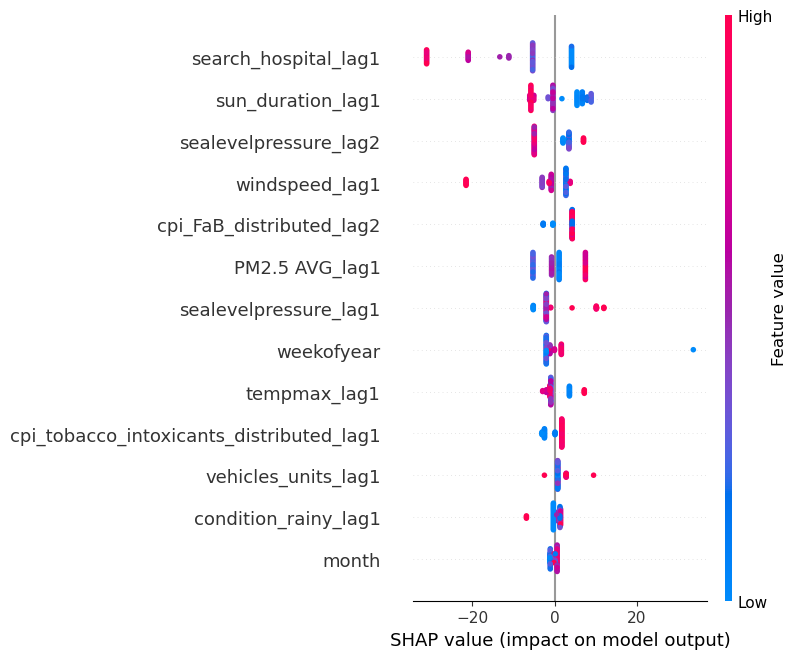

<Figure size 640x480 with 0 Axes>

In [11]:
import shap

# Create a TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(ludhiana_array_scaled)

# Create a summary plot
shap.summary_plot(shap_values, ludhiana_array_scaled, feature_names=best_features)

# Save the figure
fig = plt.gcf()  # Get the current figure
fig.savefig("shap_summary_plot_ludhiana.jpg", format='jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [12]:
import shap
from PIL import Image

# Create a TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for Nairobi
shap_values_nairobi = explainer.shap_values(nairobi_array_scaled)

# Create a summary plot for Nairobi
shap.summary_plot(shap_values_nairobi, nairobi_array_scaled, feature_names=best_features, show=False)
plt.savefig("shap_summary_plot_nairobi.png", format='png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate SHAP values for Ludhiana
shap_values_ludhiana = explainer.shap_values(ludhiana_array_scaled)

# Create a summary plot for Ludhiana
shap.summary_plot(shap_values_ludhiana, ludhiana_array_scaled, feature_names=best_features, show=False)
plt.savefig("shap_summary_plot_ludhiana.png", format='png', dpi=300, bbox_inches='tight')
plt.close()

# Open the two images and combine them
image1 = Image.open("shap_summary_plot_nairobi.png")
image2 = Image.open("shap_summary_plot_ludhiana.png")
combined = Image.new('RGB', (image1.width + image2.width, image1.height))
combined.paste(image1, (0, 0))
combined.paste(image2, (image1.width, 0))
combined.save("combined.png")


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


invalid value encountered in divide
invalid value encountered in divide


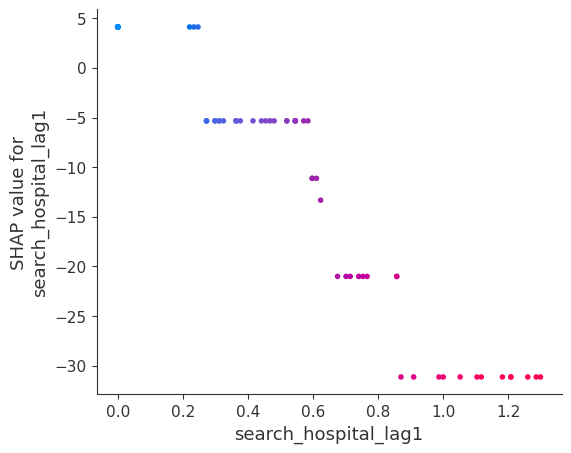

invalid value encountered in divide
invalid value encountered in divide


<Figure size 640x480 with 0 Axes>

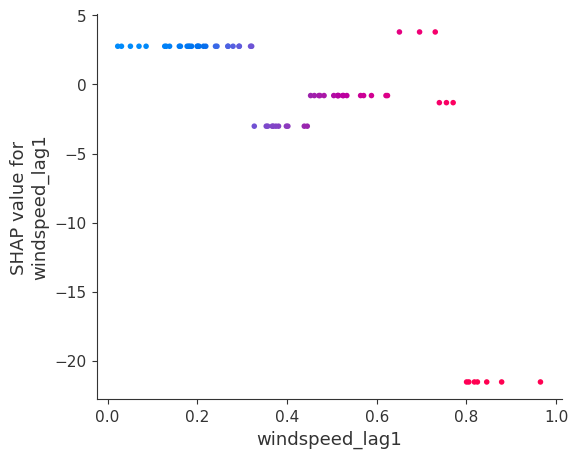

<Figure size 640x480 with 0 Axes>

In [34]:
feature_name = 'search_hospital_lag1'
shap.dependence_plot(feature_name, shap_values, ludhiana_array_scaled, feature_names=best_features)
plt.savefig("shap_dependence_plot_ludhiana_most_important_Feature.jpg", format='jpg', dpi=300, bbox_inches='tight')

feature_name = 'windspeed_lag1'
shap.dependence_plot(feature_name, shap_values, ludhiana_array_scaled, feature_names=best_features)
plt.savefig("shap_dependence_plot_ludhiana_most_important_Feature.jpg", format='jpg', dpi=300, bbox_inches='tight')

## Nairobi

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


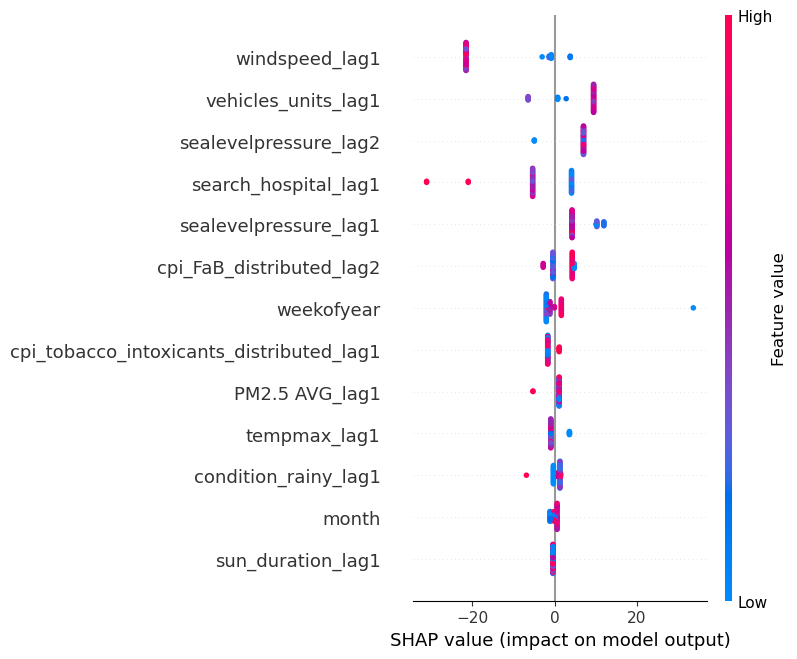

<Figure size 640x480 with 0 Axes>

In [23]:
# Create a TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(nairobi_array_scaled)

# Create a summary plot
shap.summary_plot(shap_values, nairobi_array_scaled, feature_names=best_features)
plt.tight_layout()  # Adjust layout
plt.savefig("shap_summary_plot_nairobi.jpg", format='jpg', dpi=300, bbox_inches='tight')


In [ ]:
# Create a summary plot and directly save it to a file
fig, ax = plt.subplots(1, 1)
shap.summary_plot(shap_values, nairobi_array_scaled, feature_names=best_features, show=False)
plt.savefig("shap_summary_plot_nairobi_new.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.close(fig)

In [30]:
# Convert the SHAP values to a DataFrame for easier manipulation
shap_df = pd.DataFrame(shap_values, columns=best_features)

shap_df.to_csv('shap_results_nairobi.csv')

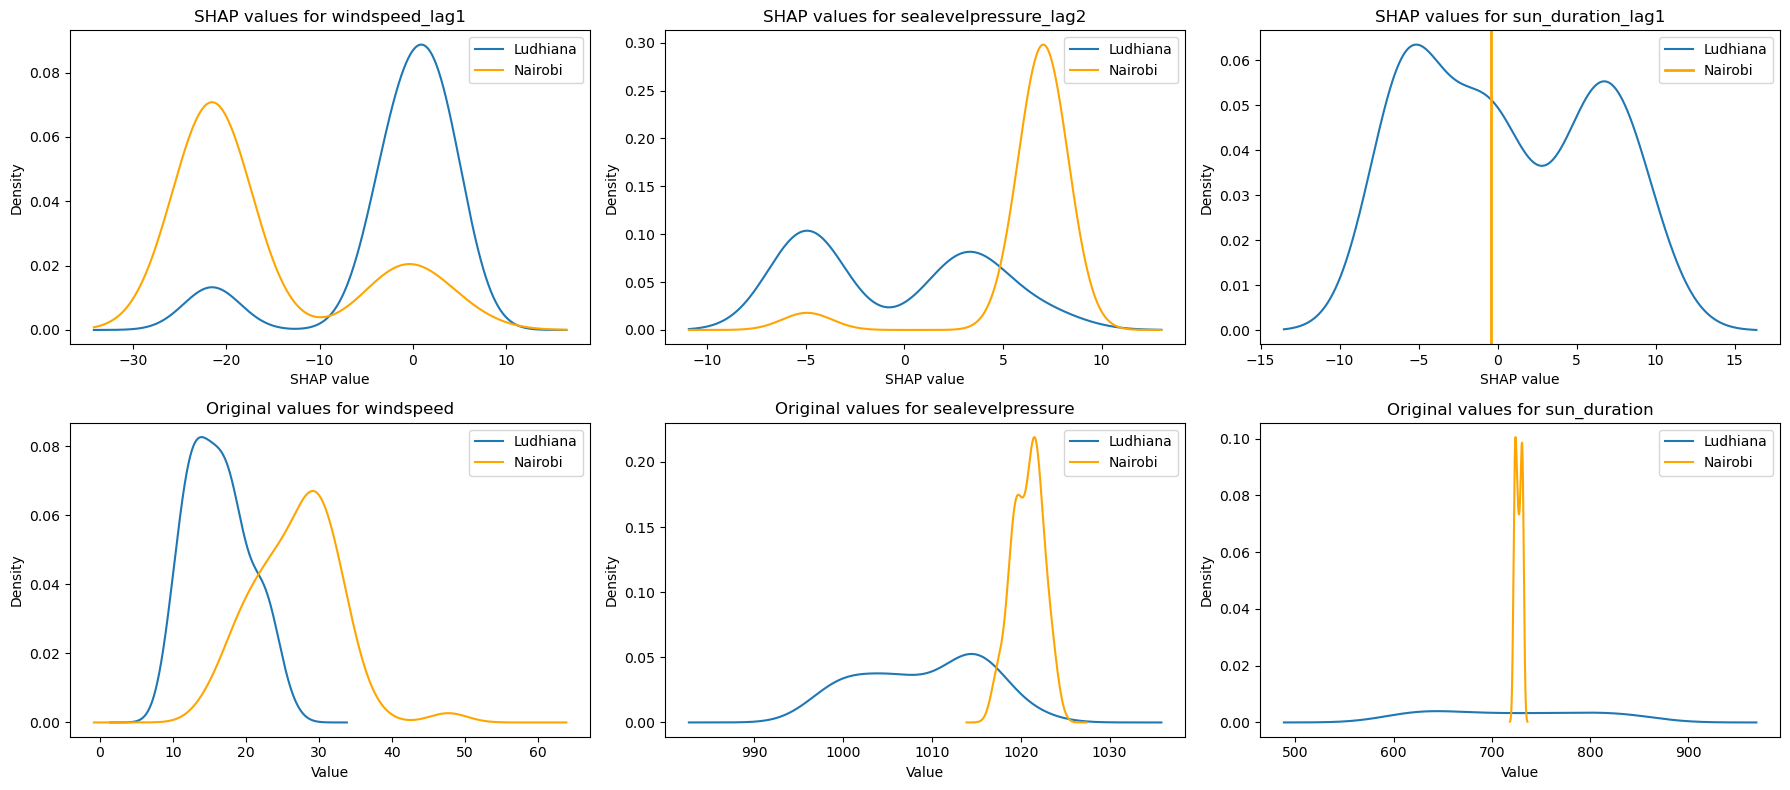

In [17]:
# Create a TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the ludhiana data
shap_values_ludhiana = explainer.shap_values(ludhiana_array_scaled)
shap_df_ludhiana = pd.DataFrame(shap_values_ludhiana, columns=ludhiana_final.drop('Predicted_Admissions', axis=1).columns)

# Calculate SHAP values for the nairobi data
shap_values_nairobi = explainer.shap_values(nairobi_array_scaled)
shap_df_nairobi = pd.DataFrame(shap_values_nairobi, columns=nairobi_final.drop('Predicted_Admissions', axis=1).columns)


features = ['windspeed_lag1', 'sealevelpressure_lag2', 'sun_duration_lag1']

# Create a grid of plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

# Flatten the axes array to loop over it
axes = axes.flatten()

# Loop over each feature
for feature, ax1, ax2 in zip(features, axes[:3], axes[3:]):
    # First row: SHAP values
    # Plot density plot for Ludhiana SHAP values
    shap_df_ludhiana[feature].plot(kind='density', color='tab:blue', label='Ludhiana', ax=ax1)
    
    # Plot density plot for Nairobi SHAP values
    if feature == 'sun_duration_lag1':
        ax1.axvline(x=shap_df_nairobi[feature].mean(), color='orange', linewidth=2, label='Nairobi')
    else:
        shap_df_nairobi[feature].plot(kind='density', color='orange', label='Nairobi', ax=ax1)

    ax1.set_title('SHAP values for ' + feature)
    ax1.set_xlabel('SHAP value')
    ax1.legend()

    # Second row: Original feature values
    # Plot density plot for Ludhiana original feature values
    ludhiana_df[feature[:-5]].plot(kind='density', color='tab:blue', label='Ludhiana', ax=ax2)
    
    # Plot density plot for Nairobi original feature values
    nairobi_df[feature[:-5]].plot(kind='density', color='orange', label='Nairobi', ax=ax2)

    ax2.set_title('Original values for ' + feature[:-5])
    ax2.set_xlabel('Value')
    ax2.legend()

plt.tight_layout()
plt.savefig("shap_inspection_distribution_comparison.jpg", format='jpg', dpi=300)
plt.show()



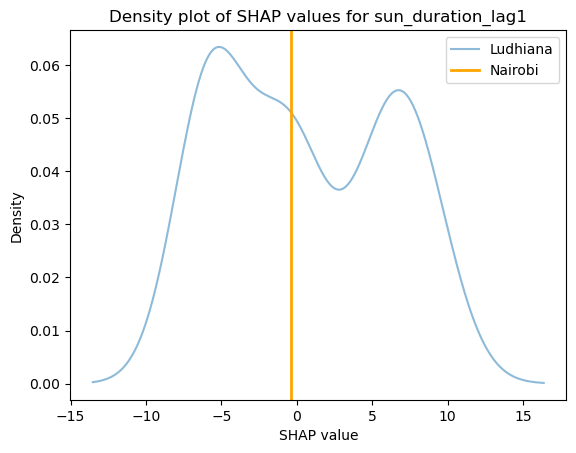

In [45]:
# Plot density of SHAP values for Ludhiana
shap_values_ludhiana_feature.plot(kind='density', color='tab:blue', alpha=0.5, label='Ludhiana')



plt.title('Density plot of SHAP values for ' + feature)
plt.xlabel('SHAP value')
plt.ylabel('Density')
plt.legend()
plt.show()
